In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [19]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5
DATA_DIR = "/content/fruit_subset_100"


In [20]:
import zipfile

with zipfile.ZipFile("fruit_subset_100.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fruit_subset_100")

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/fruit_subset_100",
    validation_split=0.2,
    subset="training",
    seed=123,  # <-- this is important
    image_size=(224, 224),
    batch_size=32
)

val_ds_224 = tf.keras.utils.image_dataset_from_directory(
    "/content/fruit_subset_100",
    validation_split=0.2,
    subset="validation",
    seed=123,  # <-- same seed as above!
    image_size=(224, 224),
    batch_size=32
)



Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [22]:
class_names = val_ds_224.class_names
print("Class names:", class_names)


Class names: ['Apple_5', 'Banana_1', 'Cherry_1', 'Kiwi_1', 'Orange_1']


In [23]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Get true labels
y_true = np.concatenate([y for x, y in val_ds_224], axis=0)

# One-hot encode
y_true_onehot = to_categorical(y_true, num_classes=len(class_names))


In [24]:
baseline_model = tf.keras.models.load_model("/content/resnet50_baseline.keras")
augmented_model = tf.keras.models.load_model("/content/resnet50_augmented.keras")


In [32]:
y_pred_baseline = baseline_model.predict(val_ds_224)
y_pred_augmented = augmented_model.predict(val_ds_224)



4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


In [33]:
def plot_roc_curves(y_true_bin, y_pred_probs, model_name):
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
# Extract true labels from the validation dataset
y_true = np.concatenate([y.numpy() for x, y in val_ds_224], axis=0)

# One-hot encode the labels for ROC curve
from tensorflow.keras.utils import to_categorical
y_true_binarized = to_categorical(y_true, num_classes=len(class_names))

print("Shape of binarized labels:", y_true_binarized.shape)


Shape of binarized labels: (100, 5)


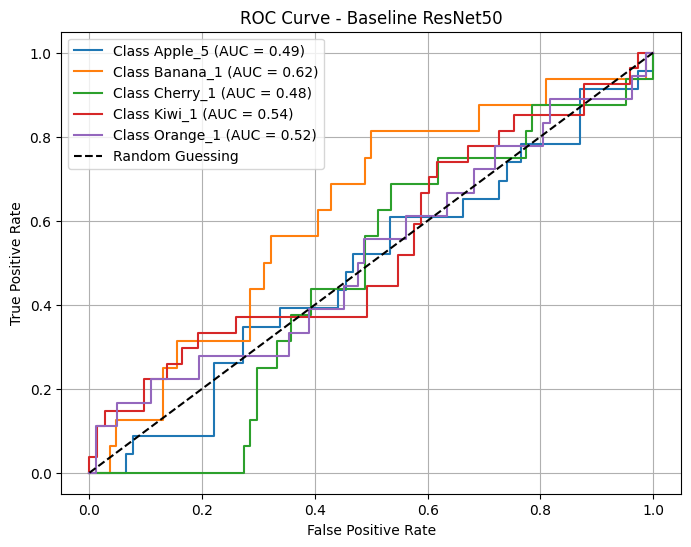

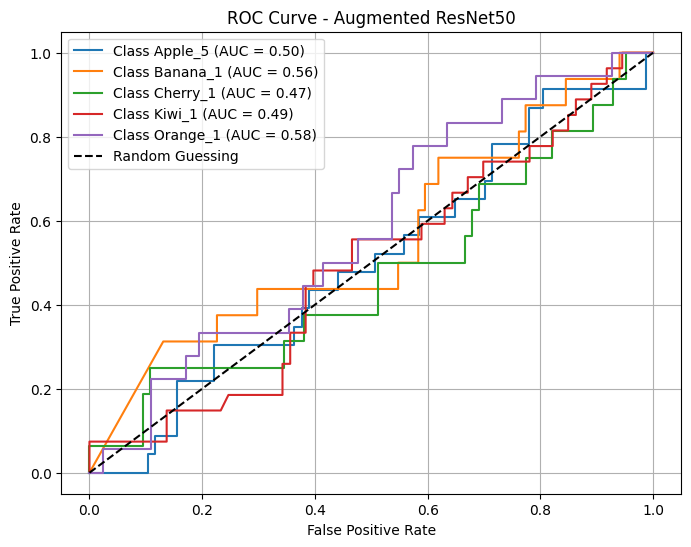

In [35]:
plot_roc_curves(y_true_binarized, y_pred_baseline, "Baseline ResNet50")
plot_roc_curves(y_true_binarized, y_pred_augmented, "Augmented ResNet50")


In [36]:
import collections

# Re-extract y_true from val_ds_224
y_true = np.concatenate([y.numpy() for x, y in val_ds_224], axis=0)

# Count number of samples per class
counter = collections.Counter(y_true)
print("Validation class distribution:")
for idx, count in sorted(counter.items()):
    print(f"Class {class_names[int(idx)]}: {count} samples")


Validation class distribution:
Class Apple_5: 23 samples
Class Banana_1: 16 samples
Class Cherry_1: 16 samples
Class Kiwi_1: 27 samples
Class Orange_1: 18 samples


##Reflection

The ROC curve comparison between the baseline and augmented ResNet50 models shows that both performed only slightly better than random guessing, with AUC values ranging from 0.47 to 0.58. The augmented model slightly outperformed the baseline, particularly for the Orange (AUC = 0.58) and Banana (AUC = 0.56) classes, while the baseline model showed its best performance on the Kiwi class (AUC = 0.55). Overall, the performance suggests limited class separability, indicating a need for further improvements such as better data augmentation, class balancing, or fine-tuning the model architecture.